## Importing of Necessary Liberaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ruptures as rpt
import pymc as pm

import warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Reading data
df = pd.read_csv('../data/processed/processed_brent_oil_prices.csv')

In [3]:
df

,date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [5]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


## Ploting Time Series Data

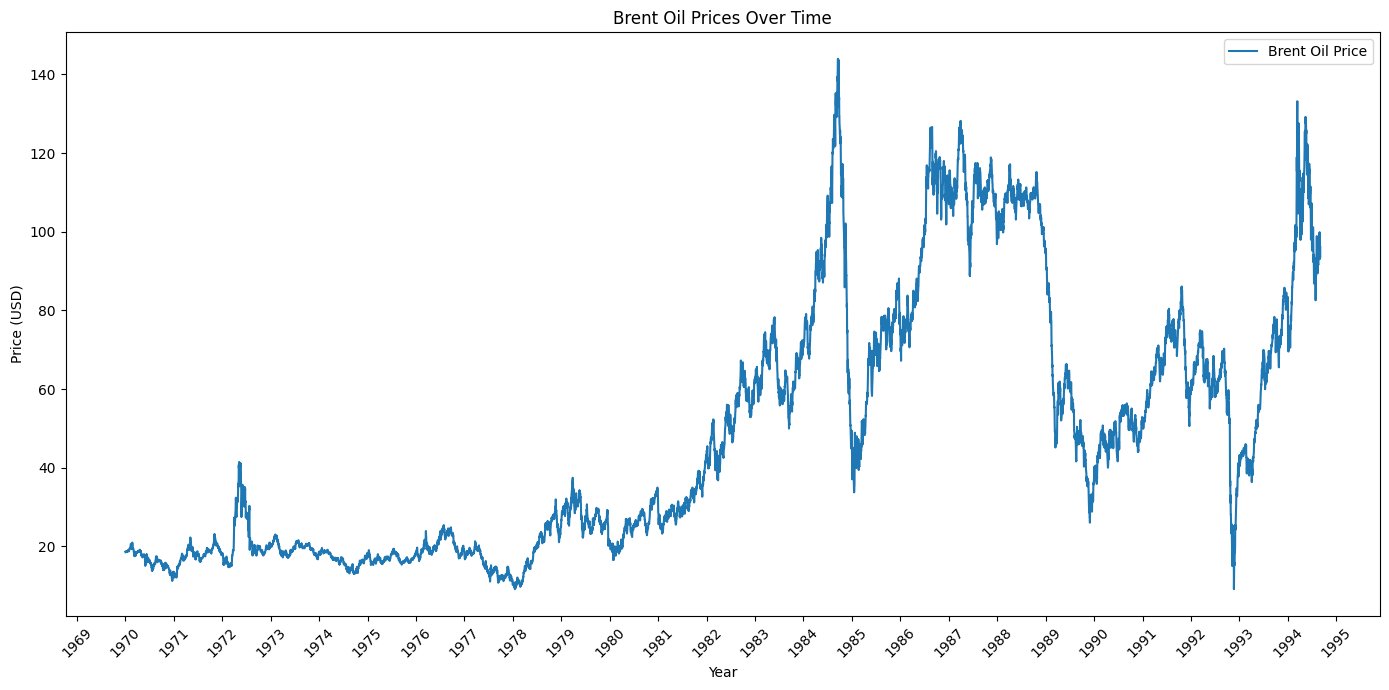

In [6]:
plt.figure(figsize=(14, 7))

# Plot the data
plt.plot(df.index, df['Price'], label='Brent Oil Price')

# Set the date format on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format for the ticks

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

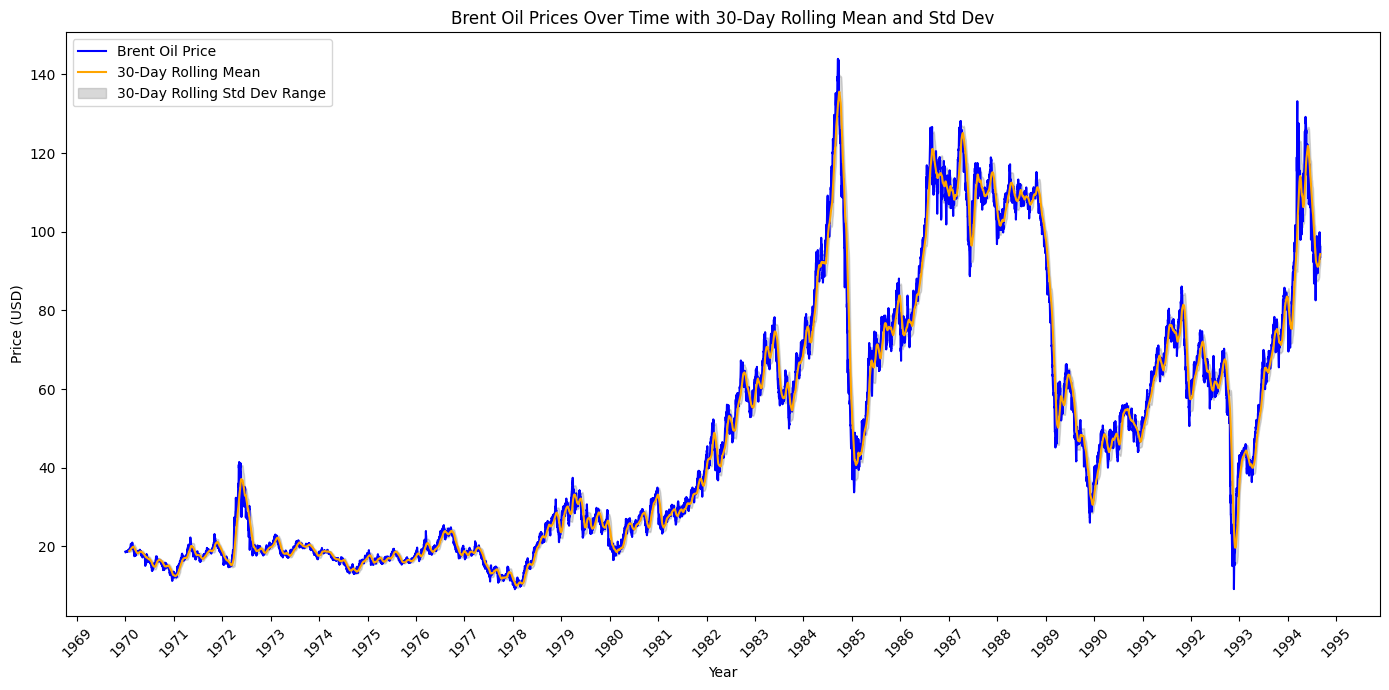

In [7]:
import matplotlib.dates as mdates

# Calculate 30-day rolling mean and standard deviation if not already calculated
df['30-day Rolling Mean'] = df['Price'].rolling(window=30).mean()
df['30-day Rolling Std'] = df['Price'].rolling(window=30).std()

plt.figure(figsize=(14, 7))

# Plot the data
plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
plt.plot(df.index, df['30-day Rolling Mean'], label='30-Day Rolling Mean', color='orange')

# Fill between to show the 30-day rolling standard deviation range
plt.fill_between(df.index, 
                 df['30-day Rolling Mean'] - df['30-day Rolling Std'], 
                 df['30-day Rolling Mean'] + df['30-day Rolling Std'], 
                 color='gray', alpha=0.3, label='30-Day Rolling Std Dev Range')

# Set the date format on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format for the ticks

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time with 30-Day Rolling Mean and Std Dev')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

## Distribution of price

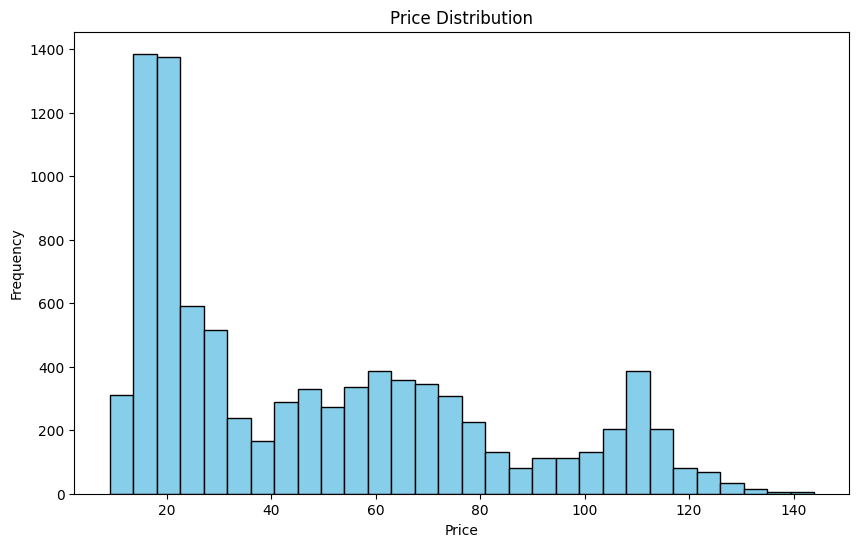

In [7]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### CUSUM (cumulative sum) method of Change Point Detection

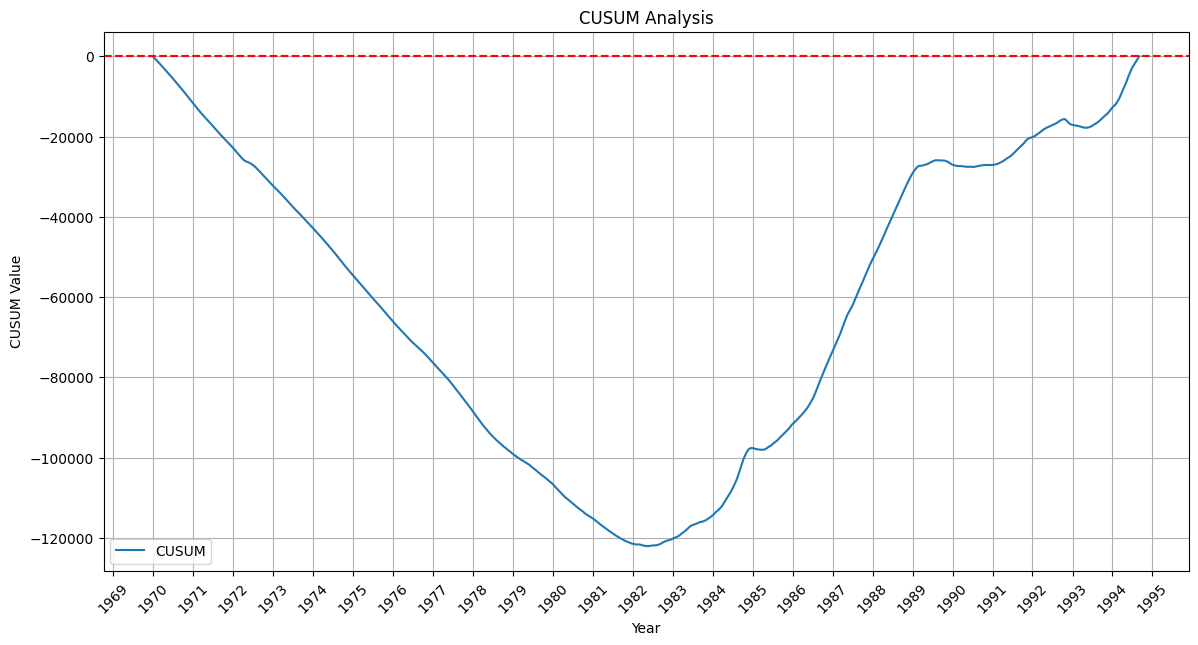

In [8]:
import matplotlib.dates as mdates

mean_price = df['Price'].mean()
cusum = np.cumsum(df['Price'] - mean_price)

plt.figure(figsize=(14, 7))
plt.plot(df.index, cusum, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')

# Format the x-axis to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

plt.xlabel('Year')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Analysis')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

## Bayesian Change Point Detection using PyMC

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mean_prior]
>Metropolis: [change_point]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1170 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


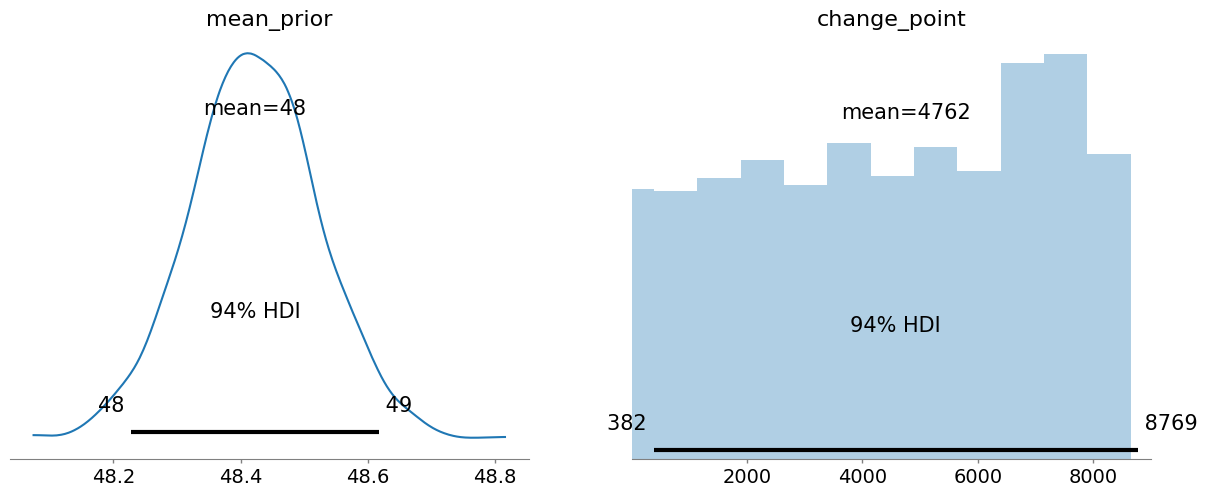

In [10]:

# Bayesian Change Point Detection using PyMC
with pm.Model() as model:
    # Priors
    mean_prior = pm.Normal('mean_prior', mu=mean_price, sigma=10)
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(df)-1)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mean_prior, sigma=10, observed=df['Price'])

    # Inference
    trace = pm.sample(1000, tune=1000, cores=2)

# Plot results
pm.plot_posterior(trace)
plt.show()

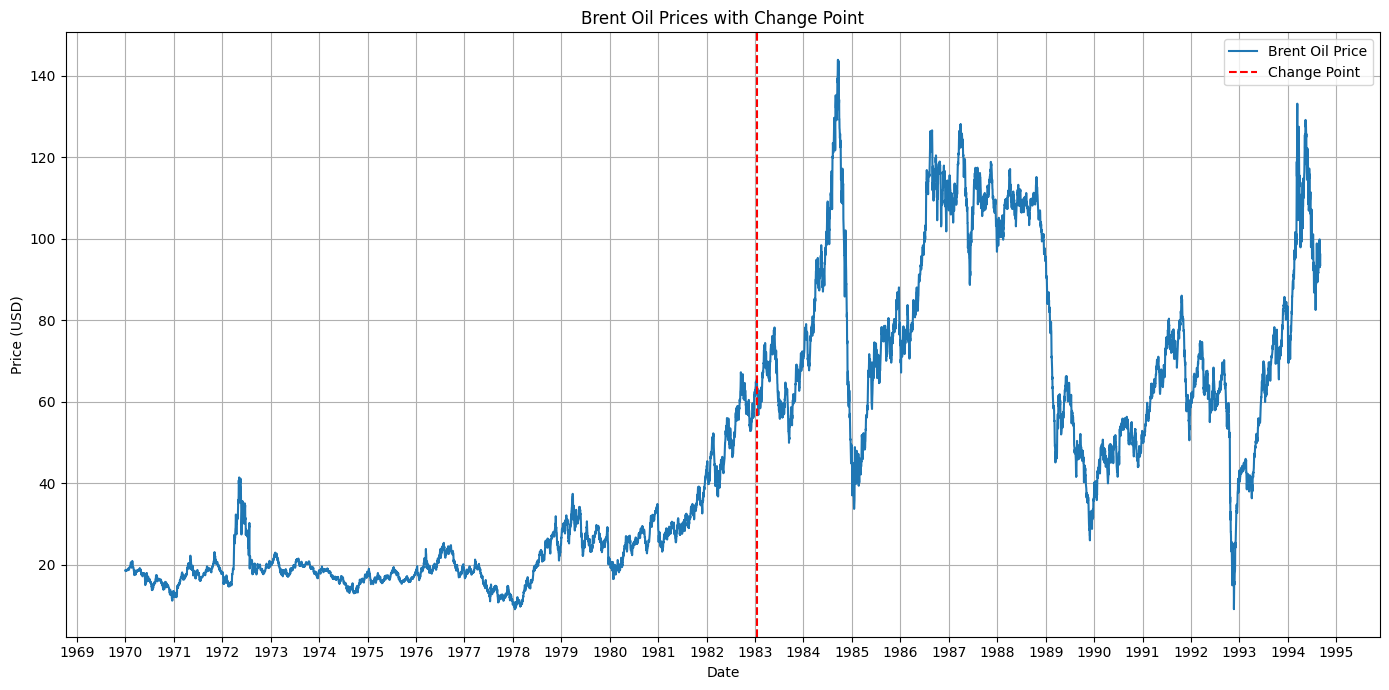

In [14]:
import matplotlib.dates as mdates

change_point_index = 4762

# Plot the data with the change point
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')

# Add the change point
plt.axvline(x=df.index[change_point_index], color='red', linestyle='--', label='Change Point')

# Set the date format on the x-axis to display yearly ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format for the ticks

# Additional plot settings
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Change Point')
plt.legend()
plt.grid()  # Optional: Add a grid for better readability

# Show the plot
plt.tight_layout()
plt.show()

## Brent Oil Prices with Detected Change Points

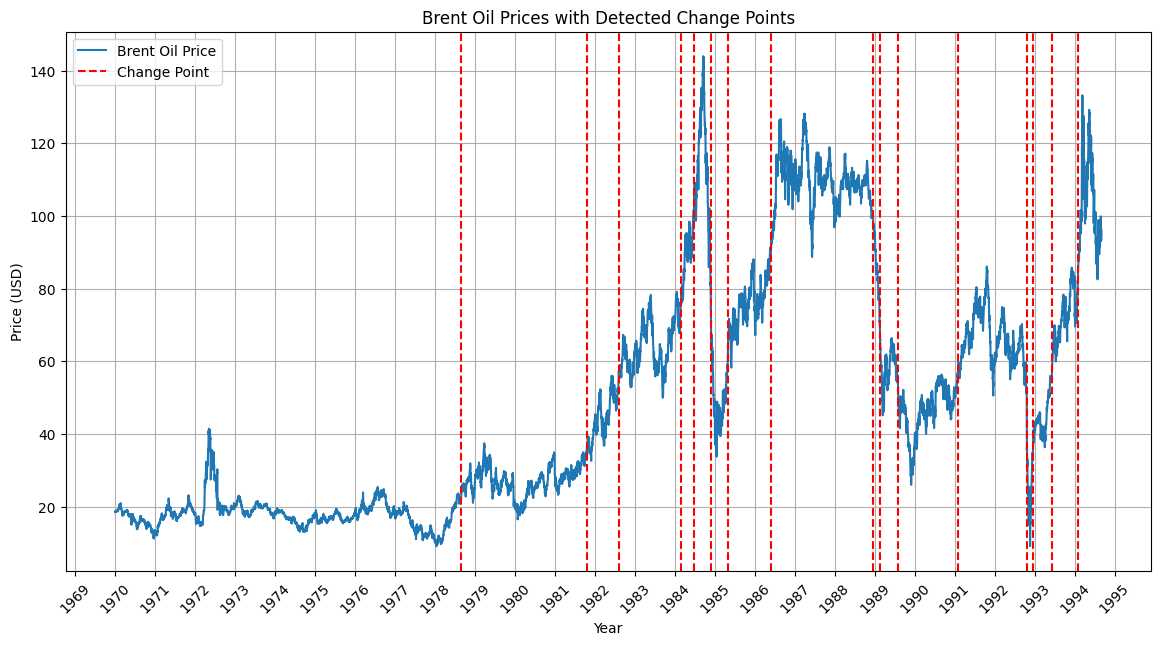

In [12]:
price_array = df['Price'].values
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_array)
change_points = algo.predict(pen=20)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')

# Add vertical lines for detected change points
for cp in change_points[:-1]:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

# Set the date format on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format for the ticks

plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(True)
plt.show()